Step $2$: handling the case in which the barcode is rotated, i.e. the bars are horizontal. Indeed, we want to achieve the situation in which all barcode bars are perfectly vertical.

We need to do the following things.
1. Understand if the barcode is rotated (i.e. horizontal bars) or not (i.e. vertical bars). For doing so, the vertical and horizontal gradient images are computed: if the sum over the former is bigger of the sum over the latter, then this means that the barcode is rotated, i.e. horizontal bars.
2. If the barcode is rotated, we need to fix this situation. We need to:
    - Rotate the image, s.t. the bars are perfectly vertical
    - Rotate the bounding box accordingly

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math

In [2]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [4]:
image_path = f'../images/{images_paths[10]}'

(1024, 1280, 3)


Text(0.5, 1.0, 'Original image')

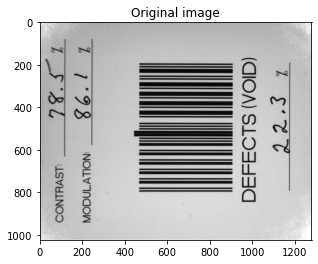

In [5]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[455., 180.],
       [923., 181.],
       [453., 813.],
       [921., 815.]], dtype=float32)

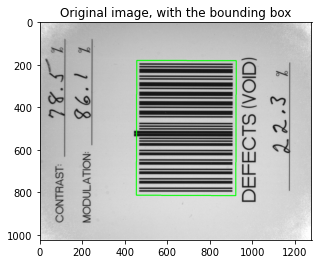

In [6]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

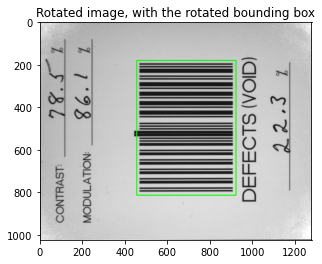

In [7]:
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=True)

In [8]:
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)

In [9]:
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                     int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

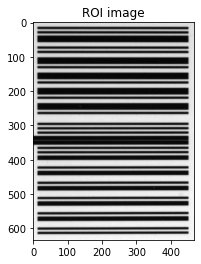

In [10]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

In the ROI image, the bars are perfectly horizontal, instead of perfectly vertical...

## UNDERSTANDING IF THE BARCODE IS ROTATED OR NOT

In [12]:
# Understand if the barcode is rotated (i.e. horizontal bars) or not.
# For doing so, we compute the horizontal and vertical gradient images: if the sum on the latter is bigger than the sum 
# on the former, this means that the barcode is rotated.
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(roi_image, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(roi_image, ddepth=ddepth, dx=0, dy=1, ksize=-1)
barcode_rotated = cv2.convertScaleAbs(gradY).sum()>cv2.convertScaleAbs(gradX).sum()

barcode_rotated

True

The following operations are pefromed only in the case in which the barcode is rotated.

## ROTATING THE IMAGE FOR HAVING THE BARS PERFECTLY VERTICAL

We define a warping/homography from the current image to the rotated image in which the bars are perfectly vertical: this is our rotation.

In [14]:
height, width = gray.shape

In [15]:
# Source points for computing the homography. These are the four verteces of the current image
# N.B. : with "current image" we mean the image obtained after the rotation performed before (rotation for making the 
# bounding box perfectly aligned)
coordinates_source = np.array([[0, 0],
                               [width-1, 0],
                               [0, height-1],
                               [width-1, height-1]], dtype='float32')

# Dimensions of the destination image (i.e. rotated image)
destination_height, destination_width = width, height

# Corresponding destination points, for computing the homography. These are the corresponding four verteces of the rotated 
# image.
coordinates_destination = np.array([[destination_width-1, 0],
                                        [destination_width-1, destination_height-1],
                                        [0, 0],                                        
                                        [0, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography/warping. It's a rotation
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation: we rotate the current image
gray_rot_rot = cv2.warpPerspective(gray_rot, H, (destination_width, destination_height))

image_rot_rot = cv2.warpPerspective(image_rot, H, (destination_width, destination_height))

Text(0.5, 1.0, 'Image after fixing the horizontal-bars issue')

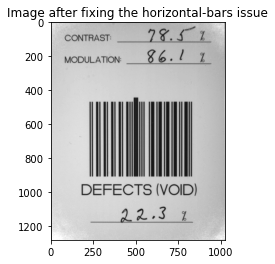

In [16]:
plt.figure()
plt.imshow(gray_rot_rot, 'gray')
plt.title('Image after fixing the horizontal-bars issue')

## ROTATING THE BOUNDING BOX ACCORDINGLY

We rotate also the bounding box points accordingly. For doing this, we apply the same homography just computed.

N.B. : we trasform the current bounding box, which is the one obtained after the first rotation (i.e. rotation for making the bounding box perfectly aligned).

In [18]:
bb_points_sorted_rot_rot = cv2.perspectiveTransform(bb_points_sorted_rot.reshape(-1,1,2),H)
bb_points_sorted_rot_rot = bb_points_sorted_rot_rot[:,0,:]

Now the width and height of the bounding box are swapped.

In [25]:
bb_width, bb_height = bb_height, bb_width

## SORTING THE BOUNDING BOX POINTS

The points in the new bounding box are not necessarily sorted anymore: we want to sort them again, still according to the ordering upper-left -> upper-right -> lower-left -> lower-right.

In [19]:
min_width = bb_points_sorted_rot_rot[:,0].min()
min_height = bb_points_sorted_rot_rot[:,1].min()
max_width = bb_points_sorted_rot_rot[:,0].max()
max_height = bb_points_sorted_rot_rot[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
bb_points_sorted_rot_rot = np.array(sorted([tuple(v) for v in bb_points_sorted_rot_rot], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

## VISUALIZATION

In [20]:
def sort_bb_points_for_visualization(bb_points_sorted):
    """Function which sorts the bb points differently, for making the bb compliant with the visualization API"""
    bb_rot = bb_points_sorted.copy()
    bb_rot[2, :] = bb_points_sorted[3, :]
    bb_rot[3, :] = bb_points_sorted[2, :]
    return bb_rot.astype(int)

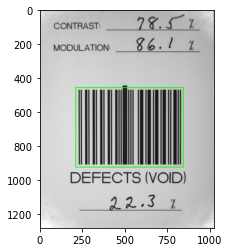

In [21]:
# Draw a bounding box around the detected barcode and display the image
image_rot_rot_bb = image_rot_rot.copy()
cv2.drawContours(image_rot_rot_bb, [sort_bb_points_for_visualization(bb_points_sorted_rot_rot)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_rot_bb, 'gray')

## ROI IMAGE

The new ROI image is therefore the following.

In [26]:
roi_image_rot = gray_rot_rot[int(bb_points_sorted_rot_rot[0][1]):int(bb_points_sorted_rot_rot[0][1]+bb_height), int(bb_points_sorted_rot_rot[0][0]):int(bb_points_sorted_rot_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

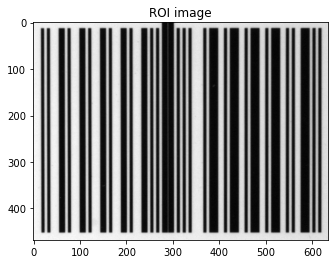

In [28]:
plt.figure()
plt.imshow(roi_image_rot, 'gray')
plt.title('ROI image')